Initial Model Accuracy (Before Tuning): 0.7762

Best Hyperparameters Found via Bayesian Optimization:
{'n_estimators': np.int64(296), 'max_depth': np.int64(76), 'min_samples_split': np.int64(49), 'max_features': np.str_('log2')}
Best Validation Accuracy via Bayesian Optimization: 0.8112


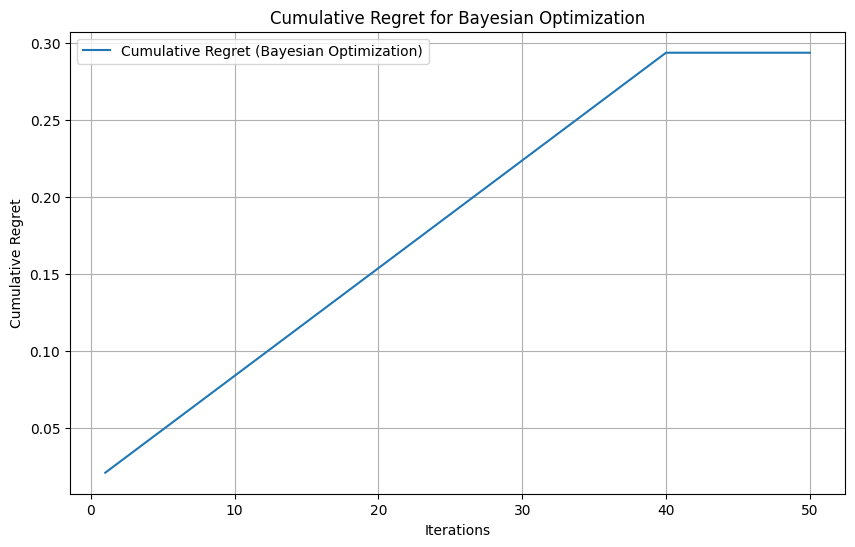

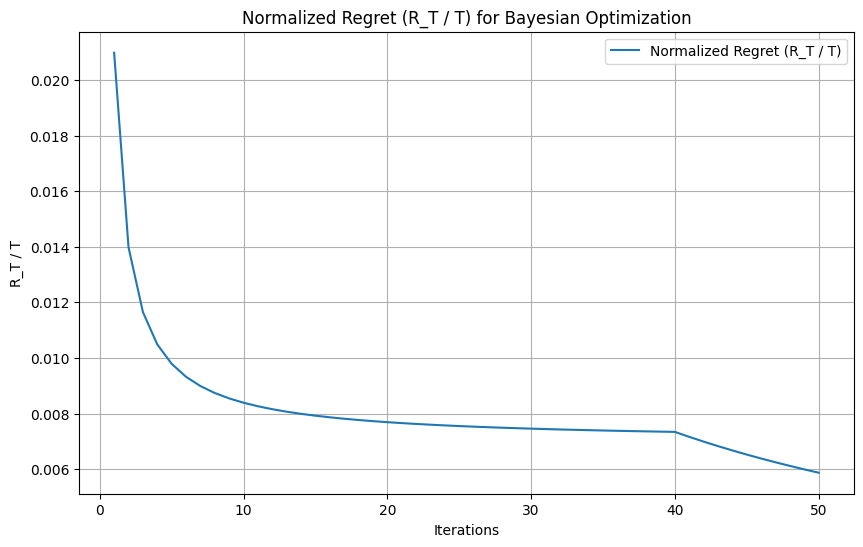

In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from skopt import gp_minimize
from skopt.space import Integer, Categorical
from skopt.utils import use_named_args
import matplotlib.pyplot as plt

# Load the Titanic dataset
data = pd.read_csv('train.csv')

# Preprocessing steps
# Drop unnecessary columns
data = data.drop(['Cabin', 'Ticket', 'Name', 'PassengerId'], axis=1)

# Drop rows with missing values
data = data.dropna()

# Encode categorical variables
label_encoders = {}
for column in ['Sex', 'Embarked']:
    le = LabelEncoder()
    data[column] = le.fit_transform(data[column])
    label_encoders[column] = le

# Split the data into features and target
X = data.drop('Survived', axis=1)
y = data['Survived']

# Split the dataset into training and validation sets
X_train, X_valid, y_train, y_valid = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Train and Evaluate the Initial Model
initial_model = RandomForestClassifier(
    n_estimators=50,
    max_depth=None,
    min_samples_split=2,
    max_features='sqrt',
    random_state=42
)
initial_model.fit(X_train, y_train)
initial_y_pred = initial_model.predict(X_valid)
initial_accuracy = accuracy_score(y_valid, initial_y_pred)
print(f"Initial Model Accuracy (Before Tuning): {initial_accuracy:.4f}")

# Define the search space for Bayesian Optimization
space = [
    Integer(50, 300, name='n_estimators'),
    Integer(5, 100, name='max_depth'),
    Integer(2, 50, name='min_samples_split'),
    Categorical(['sqrt', 'log2', None], name='max_features')
]

# Define the objective function for Bayesian Optimization
@use_named_args(space)
def objective(**params):
    model = RandomForestClassifier(
        n_estimators=params['n_estimators'],
        max_depth=params['max_depth'],
        min_samples_split=params['min_samples_split'],
        max_features=params['max_features'],
        random_state=42
    )
    model.fit(X_train, y_train)
    y_pred = model.predict(X_valid)
    accuracy = accuracy_score(y_valid, y_pred)
    return -accuracy  # Minimize negative accuracy

# Run Bayesian Optimization
n_calls = 50  # Number of iterations for tuning
result = gp_minimize(objective, space, n_calls=n_calls, random_state=42)

# Retrieve the best parameters and accuracy
best_params_bo = {
    'n_estimators': result.x[0],
    'max_depth': result.x[1],
    'min_samples_split': result.x[2],
    'max_features': result.x[3]
}

print("\nBest Hyperparameters Found via Bayesian Optimization:")
print(best_params_bo)

# Train and evaluate the final model with the best parameters
final_model_bo = RandomForestClassifier(
    n_estimators=best_params_bo['n_estimators'],
    max_depth=best_params_bo['max_depth'],
    min_samples_split=best_params_bo['min_samples_split'],
    max_features=best_params_bo['max_features'],
    random_state=42
)
final_model_bo.fit(X_train, y_train)
final_y_pred_bo = final_model_bo.predict(X_valid)
final_accuracy_bo = accuracy_score(y_valid, final_y_pred_bo)
print(f"Best Validation Accuracy via Bayesian Optimization: {final_accuracy_bo:.4f}")

# Cumulative Regret for Bayesian Optimization
cumulative_regret_bo = []
best_possible_reward = max(initial_accuracy, final_accuracy_bo)

for i in range(1, len(result.func_vals) + 1):
    regret = best_possible_reward - (-result.func_vals[:i].min())
    if cumulative_regret_bo:
        cumulative_regret_bo.append(cumulative_regret_bo[-1] + regret)
    else:
        cumulative_regret_bo.append(regret)

# Plot cumulative regret
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(cumulative_regret_bo) + 1), cumulative_regret_bo, label="Cumulative Regret (Bayesian Optimization)")
plt.xlabel("Iterations")
plt.ylabel("Cumulative Regret")
plt.title("Cumulative Regret for Bayesian Optimization")
plt.legend()
plt.grid()
plt.show()

# Normalized Regret (R_T / T)
normalized_regret = [reg / t for reg, t in zip(cumulative_regret_bo, range(1, len(cumulative_regret_bo) + 1))]

plt.figure(figsize=(10, 6))
plt.plot(range(1, len(normalized_regret) + 1), normalized_regret, label="Normalized Regret (R_T / T)")
plt.xlabel("Iterations")
plt.ylabel("R_T / T")
plt.title("Normalized Regret (R_T / T) for Bayesian Optimization")
plt.legend()
plt.grid()
plt.show()